In [1]:
!pip install python-Levenshtein

In [2]:
from Levenshtein import distance, ratio

In [3]:
import enum
import copy
import pickle
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import T5ForConditionalGeneration, AutoTokenizer

In [4]:
# Поиск возможных замен (генерация, оценка)
def get_index(lst, targets):
  lst = np.array(lst)
  indices = np.asarray([], dtype='int32')
  for target in targets:
    temp = np.where(lst == target)[0]
    indices = np.concatenate([indices, temp], dtype='int32')
  return indices

#Dataset generation using genetic algorithm | Генерация датасета с помощью генетического алгоритма


In [ ]:
# Создание словаря омоглифов

intentionals = dict()

int_resp = requests.get("https://www.unicode.org/Public/security/latest/intentional.txt", stream=True)
for line in int_resp.iter_lines():
  if len(line):
    line = line.decode('utf-8-sig')
    if line[0] != '#':
      line = line.replace("#*", "#")
      _, line = line.split("#", maxsplit=1)
      if line[3] not in intentionals:
        intentionals[line[3]] = []
      intentionals[line[3]].append(line[7])

In [ ]:
!pip install fairseq
!pip install textdistance
!pip install pyarrow
!pip install sacremoses
!pip install fastBPE
!pip install subword_nmt

In [ ]:
from abc import ABC
from typing import List, Tuple, Callable, Dict
from fairseq.hub_utils import GeneratorHubInterface
from scipy.optimize import NonlinearConstraint, differential_evolution
from textdistance import levenshtein
import pyarrow
import sacremoses
import fastBPE
import subword_nmt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
en2fr = torch.hub.load('pytorch/fairseq',
                       'transformer.wmt14.en-fr',
                       tokenizer='moses',
                       bpe='subword_nmt').to(device)

In [ ]:
class Objective(ABC):
  """ Abstract class representing objectives for scipy's genetic algorithms."""

  def __init__(self, model: GeneratorHubInterface, input: str, max_perturbs: int, distance: Callable[[str,str],int]):
    if not model:
      raise ValueError("Must supply model.")
    if not input:
      raise ValueError("Must supply input.")

    self.model: GeneratorHubInterface = model
    self.input: str = input
    self.max_perturbs: int = max_perturbs
    self.distance: Callable[[str,str],int] = distance
    self.output = self.model.translate(self.input)

  def objective(self) -> Callable[[List[float]], float]:
    def _objective(perturbations: List[float]) -> float:
      candidate: str = self.candidate(perturbations)
      translation: str = self.model.translate(candidate)
      return -self.distance(self.output, translation)
    return _objective

  def differential_evolution(self, print_result=True, verbose=True, maxiter=60, popsize=32, polish=False) -> str:
    result = differential_evolution(self.objective(), self.bounds(),
                                    disp=verbose, maxiter=maxiter,
                                    popsize=popsize, polish=polish)
    candidate = self.candidate(result.x)
    if (print_result):
      print(f"Result: {candidate}")
      print(f"Result Distance: {result.fun}")
      print(f"Perturbation Encoding: {result.x}")
      print(f"Input Translation: {self.output}")
      print(f"Result Translation: {self.model.translate(candidate)}")
    return candidate

  def bounds(self) -> List[Tuple[float, float]]:
    raise NotImplementedError()

  def candidate(self, perturbations: List[float]) -> str:
    raise NotImplementedError()


def natural(x: float) -> int:
    """Rounds float to the nearest natural number (positive int)"""
    return max(0, round(float(x)))

In [ ]:
class HomoglyphObjective(Objective):

  def __init__(self, model: GeneratorHubInterface, input: str, max_perturbs=None, distance: Callable[[str,str],int] = levenshtein.distance, homoglyphs: Dict[str,List[str]] = intentionals, **kwargs):
    super().__init__(model, input, max_perturbs, distance)
    if not self.max_perturbs:
      self.max_perturbs = len(self.input)
    self.homoglyphs = homoglyphs
    self.glyph_map = []
    for i, char in enumerate(self.input):
      if char in self.homoglyphs:
        charmap = self.homoglyphs[char]
        charmap = list(zip([i] * len(charmap), charmap))
        self.glyph_map.extend(charmap)

  def bounds(self) -> List[Tuple[float, float]]:
    return [(-1, len(self.glyph_map)-1)] * self.max_perturbs

  def candidate(self, perturbations: List[float]) -> str:
    candidate = [char for char in self.input]
    for perturb in map(natural, perturbations):
      if perturb >= 0:
        i, char = self.glyph_map[perturb]
        candidate[i] = char
    return ''.join(candidate)

In [ ]:
f = open('jfleg.txt', 'r')
text = f.read().split('\n')
data = []
for s in text:
  new_s = s.split(' ')[:4]
  new_s.remove(',') if ',' in new_s else None
  new_s.remove("'s") if "'s" in new_s else None
  data.append(" ".join(new_s))

In [ ]:
text = pd.read_csv('unigram_freq.csv')
words = list(text['word'])
start = int(len(words)*0.8) # избегаем самые частые слова вроде предлогов и союзов
words = words[start:start+600]
for w in words:
  if len(w) > 4:
    data.append(w)
data = np.array(data)

In [ ]:
np.random.seed(42)
np.random.shuffle(data)
len(data)

In [ ]:
def experiment(model, objective, source, min_perturb, max_perturb, maxiter, popsize):
  train = []
  for i in trange(min_perturb, max_perturb, desc="Perturbations"):
    for sentence in tqdm(source, leave=False, desc="Sentences"):
      changed = objective(en2fr, sentence, max_perturbs=i).differential_evolution(print_result=False, verbose=False, maxiter=maxiter, popsize=popsize)
      train.append((changed, sentence))
  return train

In [ ]:
min_perturb = 1 # минимальное количество вмешательств
max_perturb = 5 # максимальное количество вмешательств
maxiter = 3 # количество поколений
popsize = 16 # размер популяции
ds = experiment(en2fr, HomoglyphObjective, data, min_perturb, max_perturb, maxiter, popsize)

with open('homoglyph.pkl', 'wb') as f:
  pickle.dump(ds, f)

#Dataset generation using replacement | Генерация датасета с помощью замены

In [40]:
def perturbate(homoglyphs, words, min_perturb, max_perturb):
  data = []
  target = list(homoglyphs.keys())
  for word in words:
    w = list(word)
    list_index = get_index(w, target)
    if len(list_index) >= min_perturb:
      max_index = min(len(list_index), max_perturb)
    else:
      max_index = len(list_index)
      min_perturb = 0
    for perturb in range(min_perturb, max_index + 1):
      np.random.shuffle(list_index)
      index = list_index[:perturb]
      for i in index:
        glyph = np.random.randint(0, len(homoglyphs[word[i]]))
        w[i] = homoglyphs[word[i]][glyph]
      data.append(["".join(w), word])
      w = list(word)
  data = np.array(data)
  return data

In [11]:
# Словарь омоглифов
with open("data/homoglyphs.pkl", "rb") as file:
    glyphs = pickle.load(file)

with open("data/sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [12]:
glyphs

{'a': ['à', 'á', 'à', 'â', 'ã', 'ä', 'å', 'ɑ', 'ạ', 'ǎ', 'ă', 'ȧ', 'ą', 'а'],
 'b': ['d', 'в', 'ɓ', 'ḃ', 'ḅ', 'ḇ', 'ƅ'],
 'c': ['e', 'ƈ', 'ċ', 'ć', 'ç', 'č', 'ĉ', 'с'],
 'd': ['b', 'ɗ', 'đ', 'ď', 'ɖ', 'ḑ', 'ḋ', 'ḍ', 'ḏ', 'ḓ'],
 'e': ['c',
  'é',
  'è',
  'ê',
  'ë',
  'ē',
  'ĕ',
  'ě',
  'ė',
  'ẹ',
  'ę',
  'ȩ',
  'ɇ',
  'ḛ',
  'е'],
 'f': ['ƒ', 'ḟ'],
 'g': ['q', 'ɢ', 'ɡ', 'ġ', 'ğ', 'ǵ', 'ģ', 'ĝ', 'ǧ', 'ǥ'],
 'h': ['h', 'ĥ', 'ȟ', 'ħ', 'ɦ', 'ḧ', 'ḩ', 'ⱨ', 'ḣ', 'ḥ', 'ḫ', 'ẖ'],
 'i': ['1', 'l', 'í', 'ì', 'ï', 'ǐ', 'ĭ', 'ỉ', 'ị', 'ȋ', 'ī', 'ɪ'],
 'j': ['ʝ', 'ǰ', 'ɉ', 'ĵ'],
 'k': ['k', 'k', 'c', 'ḳ', 'ḵ', 'ⱪ', 'ķ', 'к'],
 'l': ['1', 'i'],
 'm': ['n', 'ṁ', 'ṃ', 'м', 'ɱ', 'ḿ'],
 'n': ['ń', 'ṅ', 'ṇ', 'ṉ', 'ņ', 'п'],
 'o': ['0', 'ȯ', 'ọ', 'ỏ', 'ơ', 'ó', 'ö', 'ᴏ'],
 'p': ['ƿ', 'ƥ', 'ṕ', 'ṗ'],
 'q': ['g', 'ʠ'],
 'r': ['ʀ', 'ɼ', 'ɽ', 'ŕ', 'ŗ', 'ř', 'ɍ', 'ɾ', 'ȓ', 'ṙ', 'ṛ', 'ṟ'],
 's': ['ʂ', 'ś', 'ṣ', 'ṡ', 'ș', 'ŝ', 'š', 'ꜱ'],
 't': ['ţ', 'ṫ', 'ṭ', 'ț', 'ƫ'],
 'u': ['ᴜ', 'ǔ', 'ŭ', 'ü', 'ù', 'ú', 

In [41]:
min_perturb = 1
max_perturb = 20
dataset = perturbate(glyphs, sentences, min_perturb, max_perturb)

with open('data/dataset.pkl', 'wb') as f:
  pickle.dump(dataset, f)

In [43]:
dataset.shape

(66302, 2)

#Preparation for training | Подготовка к обучению

In [5]:
class AvailableCorrectors(enum.Enum):

    sage_fredt5_large = "ai-forever/sage-fredt5-large"
    sage_fredt5_distilled_95m = "ai-forever/sage-fredt5-distilled-95m"
    sage_m2m100_1B = "ai-forever/sage-m2m100-1.2B"
    sage_mt5_large = "ai-forever/sage-mt5-large"

    m2m100_1B = "ai-forever/RuM2M100-1.2B"
    m2m100_418M = "ai-forever/RuM2M100-418M"
    fred_large = "ai-forever/FRED-T5-large-spell"
    ent5_large = "ai-forever/T5-large-spell"

In [6]:
path_to_model = AvailableCorrectors.sage_fredt5_distilled_95m.value

model = T5ForConditionalGeneration.from_pretrained(path_to_model)
tokenizer = AutoTokenizer.from_pretrained(path_to_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# Если данные загружать из ранее сгенерированного файла
with open('data/dataset.pkl', 'rb') as f:
  dataset = pickle.load(f)
  dataset = np.array(dataset)

# Словарь омоглифов
with open("data/homoglyphs.pkl", "rb") as f:
    glyphs = pickle.load(f)

In [8]:
tokens = list(set().union(*glyphs.values()))
tokens = set(tokens) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(tokens))
model.resize_token_embeddings(len(tokenizer))

Embedding(50629, 512)

In [9]:
np.random.seed(42)
np.random.shuffle(dataset)

In [10]:
dataset.shape

(66302, 2)

In [11]:
prefix = "fix Homoglyphs: "
encoding_x = tokenizer([prefix + sentence for sentence in dataset[:, 0]], return_tensors='pt', padding='longest')
attention_mask = encoding_x.attention_mask
X_input_ids = encoding_x.input_ids
y_input_ids = tokenizer(dataset[:, 1].tolist(), return_tensors='pt', padding='longest').input_ids
y_input_ids[y_input_ids == tokenizer.pad_token_id] = -100

In [12]:
train_size = int(0.8*dataset.shape[0])
test_size = int(0.1*dataset.shape[0])

x_train = X_input_ids[:train_size]
train_mask = attention_mask[:train_size]
y_train = y_input_ids[:train_size]

x_valid = X_input_ids[train_size:train_size + test_size]
valid_mask = attention_mask[train_size:train_size + test_size]
y_valid = y_input_ids[train_size:train_size + test_size]

x_test = dataset[train_size + test_size:, 0]
y_test = dataset[train_size + test_size:, 1]

x_train.shape, x_valid.shape, x_test.shape

(torch.Size([53041, 144]), torch.Size([6630, 144]), (6631,))

#Training | Обучение

In [13]:
class HomoglyphDataset(Dataset):

    def __init__(self, X, mask, y):
        self.X = np.array(X)
        self.mask = np.array(mask)
        self.y = np.array(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.mask[index], self.y[index])

In [14]:
def checkHomoglyphs(output, target, glyphs):
  count = 0
  list_index = get_index(target, glyphs)
  for c in list_index:
    for glyph in glyphs[target[c]]:
      if glyph in output:
        c += 1
        break
  return count

In [15]:
def evaluate(model, dataset, check=False):
    accuracy = 0
    homoglyphs = 0
    levenshtein = []
    for sentence in dataset:
      pred = predict(model, sentence[0])[0]
      levenshtein.append(ratio(sentence[1], pred))
      if(pred == sentence[1]):
        accuracy += 1
      elif(check):
        homoglyphs += checkHomoglyphs(pred, sentence[1], glyphs)

    print(f'Accuracy: {accuracy/len(dataset)}')
    print(f'Levenshtein ratio: {np.mean(levenshtein)}')
    print(f'Amount of homoglyphs: {homoglyphs}')

def predict(model, x, prefix=""):
    encodings = tokenizer(prefix + x, return_tensors="pt").to(device)
    generated_tokens = model.generate(**encodings)
    answer = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return answer

In [16]:
class M2T():
  def __init__(self, device, dataset,
               model, tokenizer, optimizer):

    self.device = device
    self.dataset = dataset
    self.model = model
    self.tokenizer = tokenizer
    self.optimizer = optimizer

    self.best_model = copy.deepcopy(model)
    self.train_loss = []
    self.val_loss = []
    self.best_val_loss = float('inf')
    self.best_epoch = 0

  def plot_losses(self):
    c_iter = range(len(self.train_loss))

    fig = plt.figure(figsize=(15, 7), dpi=80)
    ax = fig.gca()
    ax.set_xticks(c_iter)
    plt.plot(c_iter, self.train_loss, color='orange', label='train_loss')
    plt.plot(c_iter, self.val_loss, color='blue', label='val_loss')

    plt.legend(loc='upper right')
    plt.title('Losses')
    plt.savefig('losses.png')
    plt.grid()
    plt.show()

  def fit(self, x_train, train_mask, y_train, x_train_val, valid_mask, y_train_val, epochs, learning_rate, batch_size, early_stopping_patience):

    self.model.to(self.device)
    optimizer = self.optimizer(self.model.parameters(), lr=learning_rate)

    train = self.dataset(x_train, train_mask, y_train)
    val = self.dataset(x_train_val, valid_mask, y_train_val)

    train = DataLoader(train, batch_size=batch_size, shuffle=True)
    val = DataLoader(val, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
      mean_loss = 0
      batch_n = 0
      self.model.train(True)
      print(f'epoch: {epoch + 1}/{epochs}', end=' ------ ')

      for batch_i, (x, mask, y) in enumerate(train):
        x = x.to(self.device)
        y = y.to(self.device)
        mask = mask.to(self.device)

        loss = self.model(
            input_ids=x,
            attention_mask=mask,
            labels=y,
            return_dict=True
        ).loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        mean_loss += loss.item()
        batch_n += 1

      mean_loss /= batch_n
      self.train_loss.append(mean_loss)
      print(f'loss_train: {round(mean_loss, 3)}', end=' ; ')

      self.model.eval()
      mean_loss = 0
      batch_n = 0

      for batch_i, (x, mask, y) in enumerate(val):
        x = x.to(self.device)
        y = y.to(self.device)
        mask = mask.to(self.device)

        loss = self.model(
            input_ids=x,
            attention_mask=mask,
            labels=y,
            return_dict=True
        ).loss

        mean_loss += loss.item()
        batch_n += 1

      mean_loss /= batch_n
      self.val_loss.append(mean_loss)
      print(f'loss_val: {round(mean_loss, 3)}')

      if mean_loss < self.best_val_loss:
        self.best_epoch = epoch
        self.best_val_loss = mean_loss
        self.best_model = copy.deepcopy(model)
        print('New best model.')
      elif epoch - self.best_epoch > early_stopping_patience:
        print(f'Model has not improved in the last {early_stopping_patience} epochs. Break.')
        break

In [17]:
batch_size = 32
epochs = 20
early_stop = 20
lr = 5e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

mtt_params = {
    'device': device,
    'dataset': HomoglyphDataset,
    'model': model,
    'tokenizer': tokenizer,
    'optimizer': torch.optim.Adam,
}

fit_params = {
    'x_train': x_train,
    'train_mask': train_mask,
    'y_train': y_train,
    'x_train_val': x_valid,
    'valid_mask': valid_mask,
    'y_train_val': y_valid,
    'epochs': epochs,
    'learning_rate': lr,
    'batch_size': batch_size,
    'early_stopping_patience': early_stop,
}

Device: cuda


In [18]:
mtt = M2T(**mtt_params)

In [19]:
mtt.fit(**fit_params)

epoch: 1/20 ------ loss_train: 0.15 ; loss_val: 0.009
New best model.
epoch: 2/20 ------ loss_train: 0.02 ; loss_val: 0.004
New best model.
epoch: 3/20 ------ 

KeyboardInterrupt: 

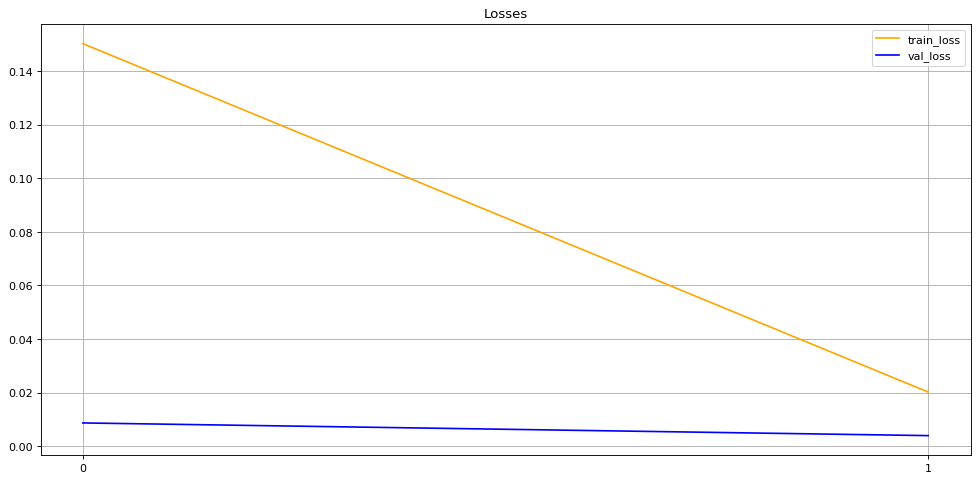

In [20]:
mtt.plot_losses()

In [21]:
torch.save(mtt.best_model.state_dict(), '/content/drive/MyDrive/homoglyphs/model1107.pth')

#Evaluation | Оценка модели

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load('/data/model.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [25]:
for i in range(120, 130):
  print(x_test[i], y_test[i])
  print("predict: ", predict(mtt.best_model, x_test[i], prefix))
  print()

Three children dressed in winter clothes are walking throuĝh the ⱳoods while pushing cargo along. Three children dressed in winter clothes are walking through the woods while pushing cargo along.
predict:  ['Three children dressed in winter clothes are walking through the woods while pushing cargo along.']

A маń iṅ b1aċк īŝ crơṡšing tḧe roăḓ. A man in black is crossing the road.
predict:  ['A man in black is crossing the road.']

A Bląĉk woɱan on the sțreet is talkīng oņ her cei1pẖońe. A Black woman on the street is talking on her cellphone.
predict:  ['A Black woman on the street is talking on her cellphone.']

An oldeɾ man inɖưlgïng ỉп a b0ttle of amber l1qüīd. An older man indulging in a bottle of amber liquid.
predict:  ['An older man indulging in a bottle of amber liquid.']

A redḥȩáded woṁan walking aċross the stṙeet. A redheaded woman walking across the street.
predict:  ['A redheaded woman walking across the street.']

A yóung màṅ ţakes a walķ çarryinq a backpaćk and caмera. A

In [23]:
data = np.stack((x_test, y_test), axis=1)
evaluate(mtt.best_model, data)

Accuracy: 0.9129844668979038
Levenshtein ratio: 0.9958707628992233
Amount of homoglyphs: 0
